# Probando Zero-Shot-Learning (ZSL) basado en CLIP para hacer un modelo de predicción de glaucoma simulando un LLM, buscando sustituir el uso de Llama o ChatGPT

***Euardo José Barrios García - alu0101341019@ull.edu.es***

En este cuaderno de Google Colab, exploro cómo usar el modelo multimodal **CLIP** para analizar imágenes de retinografías mediante Zero-Shot Learning. Usando prompts textuales específicos para simular un modelo de lenguaje médico y poniendo umbrales de detección de ejemplo, que puedan
 determinar si una imagen tiene signos de glaucoma o no.

---
**Nota:** Este experimento es un prototipo para evaluar la capacidad de CLIP en tareas médicas. **Este código es una versión muy simplificada para que pueda ejecutarse en google colab, el código final sería mucho más extenso y detallado.**


## 1. Instalamos dependencias

In [4]:

!pip install torch torchvision transformers pillow > /dev/null 2>&1
print("Dependencias instaladas.")

Dependencias instaladas.


## 2. Importación de liberías y configuración del modelo

In [5]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from google.colab import files

print("Cargando el modelo CLIP...")
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)
print("Modelo CLIP cargado exitosamente.")


Cargando el modelo CLIP...
Modelo CLIP cargado exitosamente.


## 3. Carga de lista de prompts para zero shot a modo de respuesta

In [3]:
# Lista de prompts para Zero-Shot
prompts = [
    "Esta imagen muestra signos avanzados de glaucoma.",
    "Esta imagen muestra signos tempranos de glaucoma.",
    "No hay signos visibles de glaucoma en esta imagen.",
    "Esta imagen muestra anomalías en el disco óptico relacionadas con glaucoma.",
    "Esta imagen muestra una excavación del disco óptico normal.",
    "Se observan vasos sanguíneos normales en esta imagen.",
    "Se observan vasos sanguíneos anormales en esta imagen.",
    "La imagen indica un posible adelgazamiento de la capa de fibras nerviosas.",
    "No se observan signos de neuropatía óptica en esta imagen.",
    "La excavación del disco óptico es consistente con glaucoma avanzado."
]

print("Lista de prompts cargada.")


Lista de prompts cargada.


## 3. Se añade función para realizar predicciones y generar texto

In [12]:
def generate_natural_description(image_path, prompts, threshold=0.1):
    """
    Genera una descripción narrativa natural en estilo LLM, basada en similitudes entre texto e imagen.
    Args:
        image_path (str): Ruta a la imagen de la retinografía.
        prompts (list): Lista de descripciones textuales.
        threshold (float): Umbral mínimo de probabilidad para incluir en la narrativa.
    Returns:
        str: Texto narrativo generado.
    """
    # Cargar y preprocesar la imagen
    image = Image.open(image_path).convert("RGB")
    inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)

    # Obtener las similitudes entre texto e imagen
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1).squeeze().tolist()

    # Filtrar los prompts más relevantes por probabilidad (En una versión más avanzada, habría que mejorar esto)
    relevant_prompts = [(prompt, prob) for prompt, prob in zip(prompts, probs) if prob >= threshold]
    relevant_prompts.sort(key=lambda x: x[1], reverse=True)

    # Generar una narrativa fluida, esto también debería mejorarse en versiones futuras para hacer textos (narrativas) más naturales, como un LLM.
    if relevant_prompts:
        narrative = "Tras analizar la retinografía proporcionada, se han identificado las siguientes observaciones: "
        sentences = []
        for prompt, prob in relevant_prompts:
            if "signos avanzados de glaucoma" in prompt:
                sentences.append("Se observan características que sugieren la presencia de un glaucoma avanzado, con cambios significativos en la morfología ocular.")
            elif "signos tempranos de glaucoma" in prompt:
                sentences.append("Existen indicios de un glaucoma en etapa inicial, lo que podría requerir un monitoreo cercano.")
            elif "anomalías en el disco óptico" in prompt:
                sentences.append("Se identifican anomalías en el disco óptico, que podrían estar asociadas a la progresión de glaucoma.")
            elif "excavación del disco óptico es consistente con glaucoma avanzado" in prompt:
                sentences.append("La excavación del disco óptico parece ser consistente con características avanzadas de glaucoma.")
            elif "excavación del disco óptico normal" in prompt:
                sentences.append("La excavación del disco óptico se encuentra dentro de parámetros normales, sin signos aparentes de glaucoma.")
            elif "adelgazamiento de la capa de fibras nerviosas" in prompt:
                sentences.append("Se detecta un adelgazamiento significativo en la capa de fibras nerviosas, lo cual podría estar relacionado con neuropatía óptica.")
            elif "no hay signos visibles de glaucoma" in prompt:
                sentences.append("No se observan signos visibles de glaucoma en la imagen analizada, sugiriendo una condición ocular saludable.")
            elif "vasos sanguíneos anormales" in prompt:
                sentences.append("Algunos vasos sanguíneos presentan patrones anormales que podrían requerir evaluación adicional.")
            elif "vasos sanguíneos normales" in prompt:
                sentences.append("Los vasos sanguíneos en la imagen parecen normales, sin indicios de irregularidades.")
        narrative += " ".join(sentences)
    else:
        narrative = "Tras analizar la retinografía, no se han identificado características relevantes relacionadas con glaucoma u otras condiciones oculares."

    return narrative


## 6. Botón para subir imagen y obtener descripción (Prueba 1 - Glaucoma)

Por favor, sube una imagen de retinografía:


Saving r1_Im144.png to r1_Im144.png
Imagen cargada: r1_Im144.png


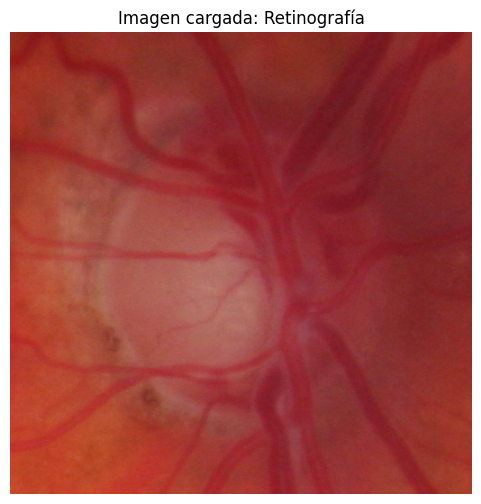


Narrativa generada:
Tras analizar la retinografía proporcionada, se han identificado las siguientes observaciones: Se identifican anomalías en el disco óptico, que podrían estar asociadas a la progresión de glaucoma. Existen indicios de un glaucoma en etapa inicial, lo que podría requerir un monitoreo cercano.


In [13]:
print("Por favor, sube una imagen de retinografía:")
uploaded = files.upload()  # Mostrar botón para cargar la imagen

# Obtener el nombre del archivo subido
image_path = next(iter(uploaded.keys()))
print(f"Imagen cargada: {image_path}")

# Mostrar la imagen subida
try:
    # Abrir y mostrar la imagen
    image = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Imagen cargada: Retinografía")
    plt.show()

    # Generar narrativa en formato natural
    narrative = generate_natural_description(image_path, prompts)
    print("\nNarrativa generada:")
    print(narrative)

except Exception as e:
    print(f"Error al procesar la imagen: {e}")



## 7. Botón para subir imagen y obtener descripción (Prueba 1 - NO Glaucoma)

Por favor, sube una imagen de retinografía:


Saving r1_Im145.png to r1_Im145.png
Imagen cargada: r1_Im145.png


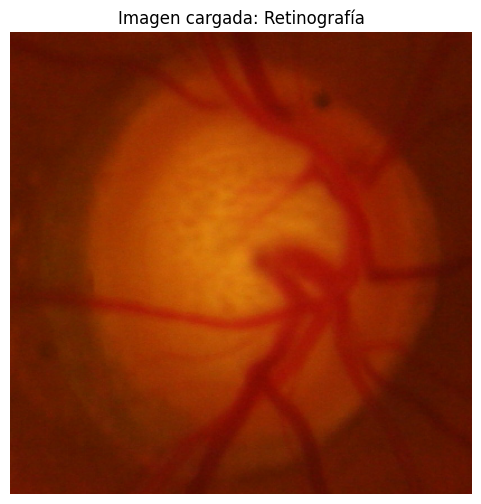


Narrativa generada:
Tras analizar la retinografía proporcionada, se han identificado las siguientes observaciones: Se identifican anomalías en el disco óptico, que podrían estar asociadas a la progresión de glaucoma.


In [15]:
print("Por favor, sube una imagen de retinografía:")
uploaded = files.upload()  # Mostrar botón para cargar la imagen

# Obtener el nombre del archivo subido
image_path = next(iter(uploaded.keys()))
print(f"Imagen cargada: {image_path}")

# Mostrar la imagen subida
try:
    # Abrir y mostrar la imagen
    image = Image.open(image_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis("off")
    plt.title("Imagen cargada: Retinografía")
    plt.show()

    # Generar narrativa en formato natural
    narrative = generate_natural_description(image_path, prompts)
    print("\nNarrativa generada:")
    print(narrative)

except Exception as e:
    print(f"Error al procesar la imagen: {e}")


# En la primera imagen, su diagnóstico es certero, no lo sé con precisión, pero la imagen subida si está etiquetada como GLAUCOMA en la BDD de RIM-ONE por lo que se podría decir que su análisis es correcto y veraz.


# Por otro lado, vemos como en la segunda prueba, donde se utiliza una imagen NO GLAUCOMA, se podría decir que CLIP, no ha identificado la enfermedad, es decir, dice que se detectan anomalias, pero no lo identifica como glaucoma diciendo otras cosas sobre la imagen, por lo que, cambiando el prompt y la forma en la que se escribe, cargándole la misma foto podría indicar NO GLAUCOMA sin ninguún tipo de problemas.


# **NOTA: Lo he probado en más casos, aunque aquí solo adjunto dos de ellos para evitar hacer el cuaderno muy extenso, pero se podría concluir que clip, en su versión base, aplicando un poco de programación de básica de python, es capaz de determinar patrones de glacuoma en retinografias, y es muy probable que, haciendo fine tuning sobre CLIP, y mejorando la semántica para generar textos que parezcan respuestas "naturales" mediante scripts de python, sea suficiente para conseguir buenos resultados.**

# **Dicho lo anterior, usar CLIP no requiere tokens de hugging face ni gastos económicos y se podría cargar este modelo sin problemas en una app final, pues su peso es de menos de 1 Gb, y su modelo con Fine Tuning podría ser 1.5 Gb o 2GB solamente.**